### Import libraries

In [414]:
import numpy as np
import scipy
import time

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from matplotlib import pyplot as plt
%matplotlib inline

### Load the Digits datatset

In [501]:
def load_digits_data():
    '''
    Loads the in-built digits dataset of sklearn, performs train-test split and standardizes the data.
    '''
    digits = datasets.load_digits()

    X = digits.data
    y = digits.target

    return split_standardize(X, y, test_size=0.25, random_state=0)

In [502]:
def split_standardize(X, y, test_size=0.25, random_state=0):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = random_state)
    print('X_train: {}, y_train: {}, X_test: {}, y_test: {}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

    # Standardize the data
    scaler = StandardScaler().fit(X_train)
    X_test = scaler.transform(X_test)
    X_train = scaler.transform(X_train)
    
    return X_train, y_train, X_test, y_test

### SVM Algorithm using Fast Gradient Descent

#### Compute K-Gram Matrix

In [416]:
def computegram(X, Z=None, kernel='poly', params={}):
    '''
    Computes the gram matrix for two input matrices using the input kernel function.
    
    Inputs: 
    - X      : Matrix with observations as rows
    - Z      : Another matrix with observations as rows
    - kernel : type of kernel - 'linear', 'poly' or 'rbf'
    - params : dictionary of parameters for the correponding kernel. 
               kernel       params keys     descr
               ---------   ------------    -------
               linear       None           No parameters expected
               rbf          sigma          Kernel Coefficient
               poly         order          Order of the polynomial
               poly         coef0          independent cofficient in kernel function
    
    Output: 
    - gram   : Gram matrix    
    
    '''
    if Z is None:
        Z = X
    # Polynomial kernel 
    if kernel == 'poly':
        gram = poly(X, Z, params)
    # Radial Basis Function Kernel
    elif kernel == 'rbf':
        gram = rbf(X, Z, params)
    # Linear Kernel
    else:
        gram = linear(X, Z, params)        

    return gram

In [417]:
def linear(X, Z, params):
    '''
    Computes the gram matrix for two input matrices for a linear kernel.
    
    Inputs: 
    - X      : Matrix with observations as rows
    - Z      : Another matrix with observations as rows
    - params : None expected
    
    Output: 
    - gram   : Gram matrix    
    
    '''    
    
    return np.dot(X, Z.T)

In [418]:
def poly(X, Z, params):
    '''
    Computes the gram matrix for two input matrices for a polynomial kernel.
    
    Inputs: 
    - X      : Matrix with observations as rows
    - Z      : Another matrix with observations as rows
    - params : dictionary of parameters for the correponding kernel. 
               params keys     descr
               ---------      ------------    
               sigma          Kernel Coefficient
    
    Output: 
    - gram   : Gram matrix    
    
    '''    
    order = params.get('order', 3)
    coef0 = params.get('coef0', 1)
    return (np.dot(X, Z.T) + coef0)**order

In [419]:
def rbf(X, Z, params):
    '''
    Computes the gram matrix for two input matrices for a polynomial kernel.
    
    Inputs: 
    - X      : Matrix with observations as rows
    - Z      : Another matrix with observations as rows
    - params : dictionary of parameters for the correponding kernel. 
               params keys     descr
               ---------      ------------    
               order          Order of the polynomial
               coef0          independent cofficient in kernel function
    
    Output: 
    - gram   : Gram matrix    
    
    '''   
    # Set the default sigma value to 0.5
    sigma = params.get('sigma', 0.5)
    
    # Z is a matrix with 2 dimensions
    if Z.ndim == 2:
        gram = np.exp( -1/(2*sigma**2) * np.linalg.norm(np.subtract(X[:,:,np.newaxis], Z[:,:,np.newaxis].T), axis=1)**2)
    # Z is a matrix with 1 dimension
    else: 
        gram = np.exp( -1/(2*sigma**2) * np.linalg.norm(np.subtract(X, Z.T), axis=1)**2)
                
    return gram

#### Test K gram matrix

In [420]:
def test_gram():  
    np.random.seed(0)
    X = np.random.randn(6, 5)
    Y = np.random.randn(7, 5)
    gram1 = computegram(X, Y, 'poly', {'order':3} )
    gram2 = metrics.pairwise.polynomial_kernel(X, Y, degree=3, gamma=1)
    assert np.allclose(gram1, gram2), 'Computed matrix' + str(gram1) + 'does not match that of scikit-learn:' + str(gram2)
    print('Test passed')
    
test_gram()

Test passed


#### Objective function for huberized hinge loss with L2 regularization

In [421]:
def obj(beta, K, y, lamb, h=0.5):
    '''
    Computes the value of the L2 regularized huberized hinge loss objective function of SVM.

    Inputs:
    - beta : Vector of coefficients to be optimized
    - K    : Gram matrix consisting of evaluations of the kernel k(x_i, x_j) for i,j=1,...,n
    - y    : Labels y_1,...,y_n corresponding to x_1,...,x_n
    - lamb : Penalty parameter lambda
    - h    : huberized hinge loss parameter
    
    Output:
    - grad : Value of the objective function at beta
    '''
    
    K_beta = np.dot(K, beta) 
    yt  = y*K_beta
    
    # Compute the huberized hinge loss   
    lhh = ((1+h-yt)**2)/(4*h)*(np.abs(1-yt) <= h) + (1-yt)*(yt<(1-h))
    
    # Gradient of huberized hinge loss function and L2 penalty term   
    obj = np.mean(lhh) + lamb*beta.dot(K_beta)
    
    return obj

#### Compute gradient of the objective function

In [422]:
def computegrad(beta, K, y, lamb, h=0.5):
    '''
    Computes the gradient of the L2 regularized huberized hinge loss objective function of SVM.
    
    Inputs:
    - beta : Vector of coefficients to be optimized
    - K    : Gram matrix of dimensions consisting of evaluations of the kernel k(x_i, x_j) for i,j=1,...,n
    - y    : Labels y_1,...,y_n corresponding to x_1,...,x_n
    - lamb : Regularization parameter lambda
    - h    : huberized hinge loss parameter    
   
    Output:
    - grad : Value of the gradient at beta    
    
    '''
    
    K_beta = np.dot(K,beta) 
    yt = y*K_beta
    
    # Compute the huberized hinge loss
    lhh = -(1+h-yt)/(2*h)*y*(np.abs(1-yt) <= h) -y*(yt<(1-h))
    
    # Gradient of huberized hinge loss function and L2 penalty term
    grad = np.mean(lhh[:,np.newaxis]*K, axis=0) + 2*lamb*K_beta

    return grad

#### Test gradient function

In [423]:
import sklearn.metrics
def test_grad(eps=1e-6):
    n = 5
    for i in range(n):
        np.random.seed(0)
        beta = -np.random.normal(size=n)
        x = np.random.randn(n, n)
        y = np.random.choice([0, 1], size=5)
        K = computegram(x)
        lamb = 0.5
        f1 = obj(beta, K, y, lamb)
        beta[i] = beta[i] + eps
        f2 = obj(beta, K, y, lamb)
        print('Estimated and calculated values of beta[', i, ']:', (f2-f1)/eps, computegrad(beta, K, y, lamb)[i])
        assert np.isclose((f2-f1)/eps, computegrad(beta, K, y, lamb)[i]), 'Estimated gradient ' + str((f2-f1)/eps) + ' is not approximately equal to the computed gradient ' + str(computegrad(beta, K, y, lamb)[i])
    print('Test passed')
  
test_grad()

Estimated and calculated values of beta[ 0 ]: -393.761700252071 -393.761686189752
Estimated and calculated values of beta[ 1 ]: -149.36243314878084 -149.36240193099178
Estimated and calculated values of beta[ 2 ]: -102.50232844555285 -102.50229287348967
Estimated and calculated values of beta[ 3 ]: -7520.762026615557 -7520.760531435922
Estimated and calculated values of beta[ 4 ]: -1588.9161004452035 -1588.915874397894
Test passed


#### Backtracking line search for step size

In [424]:
def backtracking_eta(beta, K, y, lamb, eta_init=1, a=0.5, b=0.1, maxiter=1000):
    """
    Performs backtracking line search to find the optimal step size for a given beta
    
    Inputs:
      - beta     : vector of coefficients with current values
      - K        : Gram matrix
      - y        : Vector of output labels
      - lamb     : l2 regularization parameter
      - eta_init : Starting (maximum) step size            
      - a        : Constant used to define sufficient decrease condition
      - b        : Fraction by which we decrease eta if the previous eta doesn't work
      - maxiter  : Maximum number of iterations to run the algorithm
      
    Output:
      - eta      : Optimal step size to use
          
    """    
    # Compute gradient and its norm
    grad_beta = computegrad(beta, K, y, lamb)
    norm_grad_beta = np.linalg.norm(grad_beta)
    
    # Compute current objective value
    obj_curr = obj(beta, K, y, lamb)

    # Initialize variables
    eta = eta_init 
    found_eta = 0
    iter = 0
        
    # Iterate till optimal step size is found or maximum iterations are reached.
    while found_eta == 0 and iter < maxiter:
        
        # Compute new objective
        obj_next = obj(beta - eta*grad_beta, K, y, lamb)
        
        if obj_next < obj_curr - a*eta*norm_grad_beta**2:
            # Found the optimum step size
            found_eta = 1
        elif iter == maxiter-1:
            # Max number of iterations reached
            eta = eta_init
            break
        else:
            # Reduce eta by a factor of b
            eta *= b
            iter += 1
            
    return eta

#### Fast gradient algorithm

In [425]:
def fastgradalgo(beta_init, theta_init, K, y, lamb=0, eta_init=1, max_iter=1000, eps=1e-5):
    '''
    Fast gradient descent algorithm for finding the optimal beta coefficients.
    
    Inputs:
      - beta_init  : Starting values of beta coefficients
      - theta_init : Starting values of theta coefficients
      - K          : Gram matrix
      - y          : Vector of output labels
      - lamb       : l2 regularization parameter    
      - max_iter   : Maximum number of iterations to run the algorithm      
      - eps        : Value for convergence criterion for the norm of the gradient
    
    Output:
      - beta_vals  : Matrix of estimated beta's at each iteration,
                     with the most recent values in the last row.
    
    '''       
    # Initialize variables
    beta  = beta_init
    theta = theta_init
    eta   = eta_init
    beta_vals = beta
    iter = 0
    
    # Compute gradients
    grad_theta = computegrad(theta, K, y, lamb)
    grad_beta = computegrad(beta, K, y, lamb)
    
    # Update beta till gradient is lesser than epsilon or maximum iterations are reached   
    while iter < max_iter and np.linalg.norm(grad_beta) > eps:
        
        # Get optimal step size
        eta = backtracking_eta(theta, K, y, lamb, eta_init=eta)
        
        # Compute new beta and theta
        beta_new = theta - eta*grad_theta
        theta = beta_new + iter/(iter + 3) * (beta_new - beta)
        beta = beta_new
        
        # Append the new beta values to the output beta matrix
        beta_vals = np.vstack((beta_vals, beta_new))
        
        # Recompute the gradient using new beta and theta
        grad_beta  = computegrad(beta, K, y, lamb)
        grad_theta = computegrad(theta, K, y, lamb)
        
        iter += 1
                      
    return beta_vals

#### Train SVM 

In [426]:
def train_svm(X, y, lamb=0, kernel='poly', params={}, max_iter=1000, eps=1e-3, normalize=True):
    '''
    Trains the kernel based SVM model on the training data.
    
    Inputs:
      - X          : Input feature matrix
      - y          : Vector of output labels    
      - lamb       : l2 regularization parameter    
      - kernel     : type of kernel function - 'linear', 'poly' or 'rbf'
      - params     : dictionary of parameters for the correponding kernel. 
                     kernel       params keys     descr
                     ---------   ------------    -------
                     linear       None           No parameters expected
                     rbf          sigma          Kernel Coefficient
                     poly         order          Order of the polynomial
                     poly         coef0          independent cofficient in kernel function   
      - max_iter   : Maximum number of iterations to run the algorithm      
      - eps        : Value for convergence criterion for the norm of the gradient
      - normalize  : Normalize the K gram matrix after evaluation
    
    Output:
      - beta_vals  : Matrix of estimated beta's at each iteration,
                     with the most recent values in the last row.
    '''
    # Initialize the vectors
    n = len(y)   
    beta_init = np.zeros(n)
    theta_init = np.zeros(n)

    # Compute the K-gram matrix
    K = computegram(X, X, kernel=kernel, params=params)
    
    # Normalize the gram matrix
    if normalize:
        K_diag = np.diag(K).copy()
        K = K/np.sqrt(np.outer(K_diag, K_diag))
    
    # Set eta_init based on an upper bound on the Lipschitz constant
    try:
        eta_init = 1 / scipy.linalg.eigh(2 / n * np.dot(K, K) + 2 * lamb * K, eigvals=(n - 1, n - 1),eigvals_only=True)[0]
    except np.linalg.LinAlgError:
        eta_init = 1
    
    # Run the fast gradient algorithm to optimize the beta coefficents
    beta_vals = fastgradalgo(beta_init, theta_init, K, y, lamb, eta_init, max_iter, eps)
    
    return beta_vals

#### Predict labels

In [429]:
def predict(X_trn, X_tst, beta, output='class', kernel='poly', params={}):
    """
    Predict the output class or score for given X and beta
    
    Input:
      - X_trn   : Input features of training data
      - X_tst   : Input features of test data
      - beta    : Regression coefficients to be used
      - output  : 'class' for class labels
                  'score' for score of prediction
    Output:
      - y_pred  : array of predicted class labels or scores
      
    """    
    # Initialize variables
    n = len(X_tst)
    y_vals = np.zeros(n)
    
    # Get the score of each test point
    for i in range(n):
        y_vals[i] = np.dot(computegram(X_trn, X_tst[i], kernel=kernel, params=params).T, beta)
        
    # Output the class
    if output == 'class':
        return np.sign(y_vals) 
    # Output the score
    else:
        return y_vals

#### Compute misclassification errors

In [440]:
def misclassification_error(X_trn, X_tst, y_tst, beta, kernel='poly', params={}):
    ''' 
    Calculates the misclassification error for binary classes.
    
    Inputs:
      - X_trn   : Input feature matrix for training
      - X_tst   : Input feature matrix for testing
      - y_tst   : Vector of output labels for testing. Assumes class labels start from 0,1,2...  
      - beta    : Estimated coefficients to evaluate
      - kernel  : type of kernel function - 'linear', 'poly' or 'rbf'
      - params  : dictionary of parameters for the correponding kernel. 
                     kernel       params keys     descr
                     ---------   ------------    -------
                     linear       None           No parameters expected
                     rbf          sigma          Kernel Coefficient
                     poly         order          Order of the polynomial
                     poly         coef0          independent cofficient in kernel function   
   
    Output:
      - error   : Misclassification error on test set   
    '''
    # Make the predictions
    y_preds = predict(X_trn, X_tst, beta, output='class', kernel=kernel, params=params)
    
    # Compute the misclassification error
    error = np.mean(y_tst != y_preds) 
    return error

### Test on binary classes - 0 and 1

In [430]:
digits = datasets.load_digits()

X = digits.data
y = digits.target

# Extract the first two categories 
X = X[(y == 0) | (y == 1) ]
y = y[(y == 0) | (y == 1) ]
y = np.array([ 1 if y==0 else -1 for y in y])
print(X.shape, y.shape)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Standardize the data
scaler = StandardScaler().fit(X_train)
X_test = scaler.transform(X_test)
X_train = scaler.transform(X_train)

lamb=1
kernel='poly'
params={'order':7}

beta_vals = train_svm(X_train, y_train, lamb=lamb, kernel=kernel, params=params)
print(predict(X_train, X_test, beta_vals[-1], output='class', kernel=kernel, params=params))

train_err = misclassification_error(X_train, X_train, y_train, beta_vals[-1], kernel=kernel, params=params)
test_err = misclassification_error(X_train, X_test, y_test, beta_vals[-1], kernel=kernel, params=params)

print("Misclassification error on training set with lambda={}: {}".format(lamb, train_err))
print("Misclassification error on test set with lambda={}: {}".format(lamb, test_err))

(360, 64) (360,)
(270, 64) (270,) (90, 64) (90,)
[ 1. -1.  1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1.  1.
 -1.  1. -1.  1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1. -1.
 -1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.  1.  1.
  1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.]
Misclassification error on training set with lambda=1: 0.0
Misclassification error on test set with lambda=1: 0.022222222222222223


### Test on binary classes - 2 and 3

In [431]:
digits = datasets.load_digits()

X = digits.data
y = digits.target

# Extract the first two categories 
X = X[(y == 2) | (y == 3) ]
y = y[(y == 2) | (y == 3) ]
y = np.array([ 1 if y==2 else -1 for y in y])
print(X.shape, y.shape)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Standardize the data
scaler = StandardScaler().fit(X_train)
X_test = scaler.transform(X_test)
X_train = scaler.transform(X_train)

lamb=1
kernel='poly'
params={'order':7}

beta_vals = train_svm(X_train, y_train, lamb=lamb, kernel=kernel, params=params)
print(predict(X_train, X_test, beta_vals[-1], output='class', kernel=kernel, params=params))

train_err = misclassification_error(X_train, X_train, y_train, beta_vals[-1], kernel=kernel, params=params)
test_err = misclassification_error(X_train, X_test, y_test, beta_vals[-1], kernel=kernel, params=params)

print("Misclassification error on training set with lambda={}: {}".format(lamb, train_err))
print("Misclassification error on test set with lambda={}: {}".format(lamb, test_err))

(360, 64) (360,)
(270, 64) (270,) (90, 64) (90,)
[-1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1.
 -1. -1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1. -1.
 -1. -1. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1.  1.
  1. -1.  1. -1. -1.  1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
  1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.]
Misclassification error on training set with lambda=1: 0.003703703703703704
Misclassification error on test set with lambda=1: 0.06666666666666667


#### Predict for multiclass using OneVsRest classifier outputs

In [433]:
def predict_class(X_trn, X_tst, beta_vals, kernel='poly', params={}):
    ''' 
    Returns the predicted class using the majority vote across all one-vs-rest classifiers.
    
    Inputs:
      - X_trn       : Input feature matrix for training
      - X_tst       : Input feature matrix for testing
      - beta_vals   : Matrix of estimated coefficients for all one-vs-rest classifiers
      - kernel      : type of kernel function - 'linear', 'poly' or 'rbf'
      - params      : dictionary of parameters for the correponding kernel. 
                       kernel       params keys     descr
                       ---------   ------------    -------
                       linear       None           No parameters expected
                       rbf          sigma          Kernel Coefficient
                       poly         order          Order of the polynomial
                       poly         coef0          independent cofficient in kernel function   
   
    Output:
      - final_preds : Misclassification error on test set      
    '''
    # Initialize variables
    all_preds = []
    final_preds = []    
    n = X_tst.shape[0]

    # Get predictions for each classifier
    for beta in beta_vals:
        y_preds = predict(X_trn, X_tst, beta, output='score', kernel=kernel, params=params)
        
        # Store the magnitude of the score if the specific class has a positive vote else set to zero
        all_preds.append([score if np.sign(score) == 1 else 0 for score in y_preds])

    all_pred_arr = np.array(all_preds)
   
    # Get the majority vote from the predictions using the magnitude of score
    final_preds = np.argmax(all_pred_arr, axis=0)

    return final_preds

### Cross Validation

#### K Fold cross validation

In [434]:
def run_kfold(X, y, lamb=0, folds=3, kernel='poly', params={}, max_iter=1000, eps=1e-5, verbose=False):
    '''
    Runs kfold validation for specified lambda
  
    Inputs:
      - X         : Input feature matrix
      - y         : Vector of output labels. Assumes class labels start from 0,1,2...          
      - lamb      : l2 regularization parameter
      - folds     : Folds for K Fold cross validation
      - kernel    : type of kernel function - 'linear', 'poly' or 'rbf'
      - params    : dictionary of parameters for the correponding kernel. 
                         kernel       params keys     descr
                         ---------   ------------    -------
                         linear       None           No parameters expected
                         rbf          sigma          Kernel Coefficient
                         poly         order          Order of the polynomial
                         poly         coef0          independent cofficient in kernel function   
      - max_iter  : Maximum number of iterations to run the algorithm      
      - eps       : Value for convergence criterion for the norm of the gradient
      - verbose   : Print debugging information if true
    
    Output:
      - acc       : List of accuracies for all K Folds
    '''
    # Initialize list for storing accuracies for all K Folds
    acc = []
    
    # Run KFold to get K folds of feature matrix
    kf = KFold(n_splits=folds, shuffle=True, random_state=0)
    kf.get_n_splits(X)

    # Fit SVM on every fold to get the accuracy
    for train_index, test_index in kf.split(X):
        
        # Extract the fold of data
        X_trn, X_val = X[train_index], X[test_index]
        y_trn, y_val = y[train_index], y[test_index]

        # Fit the SVM model
        beta_vals = train_svm(X_trn, y_trn, lamb=lamb, kernel=kernel, params=params, max_iter=max_iter, eps=eps)

        # Get optimal beta
        beta_opt = beta_vals[-1]

        # Compute the misclassification error and accuracy
        error = misclassification_error(X_trn, X_val, y_val, beta=beta_opt, kernel=kernel, params=params)
        acc.append(1-error)

    return acc

#### Train SVM using cross validation for binary classes

In [443]:
def train_svm_cv(X, y, lambs=[0], folds=3, kernel='poly', params={}, max_iter=1000, eps=1e-5, verbose=False):
    '''
    Perform k-fold cross validation using SVM fast gradient algorithm with huberized hinge loss and l2 regularization
    
    Inputs:
      - X         : Input feature matrix
      - y         : Vector of output labels. Assumes class labels start from 0,1,2...          
      - lambs     : a list of l2 regularization parameters to cross-validate. 
                    Only first element is used if cross_validate=False   
      - folds     : Folds for K Fold cross validation
      - kernel    : type of kernel function - 'linear', 'poly' or 'rbf'
      - params    : dictionary of parameters for the correponding kernel. 
                         kernel       params keys     descr
                         ---------   ------------    -------
                         linear       None           No parameters expected
                         rbf          sigma          Kernel Coefficient
                         poly         order          Order of the polynomial
                         poly         coef0          independent cofficient in kernel function   
      - max_iter  : Maximum number of iterations to run the algorithm      
      - eps       : Value for convergence criterion for the norm of the gradient
      - verbose   : Print debugging information if true
    
    Output:
      - beta_lamb : Optimal lambda to be used
      
    '''    
    # Initialize variables
    start_time = time.time()
    max_acc = 0
    best_lamb = 0
    
    # Loop over all lambda values and choose the one with best accuracy
    for l in lambs:
        
        if verbose:
            print("Checking lambda: ", l)
        
        # Run K-Fold cross validation to get the accuracies for all K folds
        accuracy = run_kfold(X, y, lamb=l, folds=folds, kernel=kernel, params=params, max_iter=max_iter, eps=eps, verbose=verbose)
        
        # Compute the mean accuracy
        mean_acc = np.mean(accuracy)
        if verbose:
            print("Accuracy for lambda {} : {}".format(l, mean_acc))
            
        # Update the best lambda and accuracy if a better accuracy was achieved
        if  mean_acc > max_acc:
            max_acc = mean_acc
            best_lamb = l

    if verbose:
        time_elapsed = time.time() - start_time
        print("Total time elapsed (mins):", time_elapsed/60)
    
    return best_lamb

#### Train multiclass SVM

In [436]:
def multiclass_svm(X_trn, y_trn, X_tst, y_tst, lambs=[0], folds=3, kernel='poly', params={}, 
                   max_iter=1000, eps=1e-5, cross_validate=True, verbose=False):
    ''' 
    Trains a kernel SVM classifier with L2 regularized huberized hinge loss using cross validation.
    
    Inputs:
      - X_trn          : Input feature matrix for training
      - y_trn          : Vector of output labels for training. Assumes class labels start from 0,1,2...          
      - X_tst          : Input feature matrix for testing
      - y_tst          : Vector of output labels for testing. Assumes class labels start from 0,1,2...    
      - lambs          : a list of l2 regularization parameters to cross-validate. 
                         Only first element is used if cross_validate=False   
      - folds          : Folds for K Fold cross validation
      - kernel         : type of kernel function - 'linear', 'poly' or 'rbf'
      - params         : dictionary of parameters for the correponding kernel. 
                         kernel       params keys     descr
                         ---------   ------------    -------
                         linear       None           No parameters expected
                         rbf          sigma          Kernel Coefficient
                         poly         order          Order of the polynomial
                         poly         coef0          independent cofficient in kernel function   
      - max_iter       : Maximum number of iterations to run the algorithm      
      - eps            : Value for convergence criterion for the norm of the gradient
      - normalize      : Normalize the K gram matrix after evaluation
      - cross_validate : Use cross validation if True, else fit the first lambda value passed
      - verbose   : Print debugging information if true      
    
    Output:
      - beta_vals      : Matrix of estimated beta's at each iteration,
                         with the most recent values in the last row.    
    '''
    # Initialize list to store optimal betas for all classes
    opt_betas = []
    
    # Number of classes to categorize assuming classes have values in [0,1,2,..n]
    num_classes = np.max(y_trn) + 1
    if verbose:
        print('Number of classifiers to build: ', num_classes)

    start_time = time.time()
    
    # For binary classification, only one classifier is required
    if num_classes == 2:
        num_classes = 1
    
    # Build classifier for each class
    for i in range(num_classes):
        if verbose:
            print("Building classifier for class {}..".format(i))
        X_train = X_trn
        y_train = np.array([1 if y_i == i else -1 for y_i in y_trn])
        
        if cross_validate:
            # Perform K Fold cross validation to get optimal lambda
            if verbose:
                print("Running {}-fold cross validation..".format(folds))
                
            lamb = train_svm_cv(X_train, y_train, lambs=lambs, folds=folds, kernel=kernel, 
                                params=params, max_iter=max_iter, eps=eps, verbose=verbose)
            if verbose:
                print("Optimal lambda for class {} is :{}".format(i, lamb))
                
        else:
            # Use the first element from input list as the lambda value
            lamb = lambs[0]

        # Fit the SVM on the full training data using the lambda derived above
        opt_beta_vals = train_svm(X_train, y_train, lamb=lamb, kernel=kernel, params=params, max_iter=max_iter, eps=eps)
        
        # Append the optimal betas of last iteration for each classifier
        opt_betas.append(opt_beta_vals[-1])
        
        if verbose:
            time_elapsed = time.time() - start_time
            print("Time elapsed (mins):", time_elapsed/60)
        
    # Make final predictions
    final_preds = predict_class(X_trn, X_tst, opt_betas, kernel=kernel, params=params) 
        
    # Compute accuracy
    accuracy = np.mean(final_preds == y_tst)
        
    if verbose:
        print("Accuracy on test data using {} kernel with params {}: {}".format(kernel, params, accuracy))
            
    return accuracy

#### Testing on first two categories

In [437]:
# Testing on first two categories
lambs=[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
folds=3
max_iter=500
eps=1e-5
params = {'order':7}
kernel= 'poly'
opt_lamb_cv = train_svm_cv( X_train, y_train, lambs=lambs, folds=folds, kernel=kernel, 
                            params=params, max_iter=max_iter, eps=eps, verbose=True)
            
print("Optimal lambda:", opt_lamb_cv)

lamb = opt_lamb_cv
beta_vals = train_svm(X_train, y_train, lamb=lamb, kernel=kernel, params=params, max_iter=1000, eps=1e-5)
train_err = misclassification_error(X_train, X_train, y_train, beta_vals[-1], kernel=kernel, params=params)
test_err = misclassification_error(X_train, X_test, y_test, beta_vals[-1], kernel=kernel, params=params)

print("Misclassification error on training set with lambda={}: {}".format(lamb, train_err))
print("Misclassification error on test set with lambda={}: {}".format(lamb, test_err))

Checking lambda:  0.0001
Accuracy for lambda 0.0001 : 0.974074074074074
Checking lambda:  0.001
Accuracy for lambda 0.001 : 0.974074074074074
Checking lambda:  0.01
Accuracy for lambda 0.01 : 0.9703703703703703
Checking lambda:  0.1
Accuracy for lambda 0.1 : 0.9703703703703703
Checking lambda:  1.0
Accuracy for lambda 1.0 : 0.9703703703703703
Checking lambda:  10.0
Accuracy for lambda 10.0 : 0.9703703703703703
Checking lambda:  100.0
Accuracy for lambda 100.0 : 0.9703703703703703
Total time elapsed (mins): 0.008212610085805257
Optimal lambda: 0.0001
Misclassification error on training set with lambda=0.0001: 0.007407407407407408
Misclassification error on test set with lambda=0.0001: 0.06666666666666667


### Multiclass SVM Testing

#### Load the digits dataset

In [348]:
X_train, y_train, X_test, y_test = load_digits_data()

(1347, 64) (1347,) (450, 64) (450,)


#### Polynomial with order 7

In [354]:
kernel='poly'
params={'order':7}
lambs = [1e-7, 1e-5, 1e-3]
folds=3
multiclass_svm(X_train, y_train, X_test, y_test, lambs=lambs, folds=3, kernel=kernel, params=params, 
                   max_iter=1000, eps=1e-5, cross_validate=True, verbose=True)

Number of classifiers to build:  10
Building classifier for class 0..
Running 3-fold cross validation..
Checking lambda:  1e-07
Accuracy for lambda 1e-07 : 0.9940608760207869
Checking lambda:  1e-05
Accuracy for lambda 1e-05 : 0.9948032665181885
Checking lambda:  0.001
Accuracy for lambda 0.001 : 0.9933184855233853
Total time elapsed (mins): 1.594623597462972
Optimal lambda for class 0 is :1e-05
Time elapsed (mins): 2.094407300154368
Building classifier for class 1..
Running 3-fold cross validation..
Checking lambda:  1e-07
Accuracy for lambda 1e-07 : 0.9725315515961396
Checking lambda:  1e-05
Accuracy for lambda 1e-05 : 0.9710467706013364
Checking lambda:  0.001
Accuracy for lambda 0.001 : 0.9688195991091314
Total time elapsed (mins): 1.6223305622736612
Optimal lambda for class 1 is :1e-07
Time elapsed (mins): 4.220375951131185
Building classifier for class 2..
Running 3-fold cross validation..
Checking lambda:  1e-07
Accuracy for lambda 1e-07 : 0.9769858945805495
Checking lambda:  1e

0.9288888888888889

In [410]:
kernel='poly'
params={'order':7}
lambs = [0.1]
folds=3
acc_poly_7 = multiclass_svm(X_train, y_train, X_test, y_test, lambs=lambs, folds=3, kernel=kernel, params=params, 
                            max_iter=1000, eps=1e-5, cross_validate=False, verbose=False)
print('Accuracy of kernel {} with params {} : {}'.format(kernel, params, acc_poly_7))

Accuracy of kernel poly with params {'order': 7} : 0.8844444444444445


#### Polynomial kernel with order 5

In [409]:
kernel='poly'
params={'order':5}
lambs = [0.1]
folds=3
acc_poly_5 = multiclass_svm(X_train, y_train, X_test, y_test, lambs=lambs, folds=3, kernel=kernel, params=params, 
                            max_iter=1000, eps=1e-5, cross_validate=False, verbose=False)
print('Accuracy of kernel {} with params {} : {}'.format(kernel, params, acc_poly_5))

Accuracy of kernel poly with params {'order': 5} : 0.8733333333333333


#### Polynomial kernel with order 3

In [408]:
kernel='poly'
params={}
lambs = [0.1]
folds=3
acc_poly_3 = multiclass_svm(X_train, y_train, X_test, y_test, lambs=lambs, folds=3, kernel=kernel, params=params, 
                            max_iter=1000, eps=1e-5, cross_validate=False, verbose=False)
print('Accuracy of kernel {} with params {} : {}'.format(kernel, params, acc_poly_3))

Accuracy of kernel poly with params {} : 0.8644444444444445


#### RBF kernel with sigma = 0.5

In [407]:
kernel='rbf'
params={'sigma':0.5}
lambs = [0.1]
folds=3
acc_rbf_point5 = multiclass_svm(X_train, y_train, X_test, y_test, lambs=lambs, folds=3, kernel=kernel, params=params, 
                                 max_iter=1000, eps=1e-5, cross_validate=False, verbose=False)
print('Accuracy of kernel {} with params {} : {}'.format(kernel, params, acc_rbf_point5))

Accuracy of kernel rbf with params {'sigma': 0.5} : 0.9711111111111111


#### RBF kernel with sigma = 10

In [411]:
kernel='rbf'
params={'sigma':10}
lambs = [0.1]
folds=3
acc_rbf_10 = multiclass_svm(X_train, y_train, X_test, y_test, lambs=lambs, folds=3, kernel=kernel, params=params, 
                            max_iter=1000, eps=1e-5, cross_validate=False, verbose=False)
print('Accuracy of kernel {} with params {} : {}'.format(kernel, params, acc_rbf_10))

Accuracy of kernel rbf with params {'sigma': 10} : 0.08444444444444445


#### RBF kernel with sigma = 0.1

In [405]:
kernel='rbf'
params={'sigma':0.1}
lambs = [0.1]
folds=3
acc_rbf_point1 = multiclass_svm(X_train, y_train, X_test, y_test, lambs=lambs, folds=3, kernel=kernel, params=params, 
                   max_iter=1000, eps=1e-5, cross_validate=False, verbose=False)
print('Accuracy of kernel {} with params {} : {}'.format(kernel, params, acc_rbf_point1))

Accuracy of kernel rbf with params {'sigma': 0.1} : 0.6177777777777778


### Summarize results

In [412]:
print("Accuracy on test set with lambda 0.1:")
print("Polynomial kernel of order 7: ", acc_poly_7)
print("Polynomial kernel of order 5: ", acc_poly_5)
print("Polynomial kernel of order 3: ", acc_poly_3)
print("RBF kernel with sigma 0.1: ", acc_rbf_point1)
print("RBF kernel with sigma 0.5: ", acc_rbf_point5)
print("RBF kernel with sigma 10: ", acc_rbf_10)

Accuracy on test set with lambda 0.1:
Polynomial kernel of order 7:  0.8844444444444445
Polynomial kernel of order 5:  0.8733333333333333
Polynomial kernel of order 3:  0.8644444444444445
RBF kernel with sigma 0.1:  0.6177777777777778
RBF kernel with sigma 0.5:  0.9711111111111111
RBF kernel with sigma 10:  0.08444444444444445


### Demo using real world dataset

#### RBF kernel demo with cross validation

In [448]:
# Set the parameters
kernel='rbf'
params={'sigma':0.5}
lambs = [0.01, 0.1, 1]
folds=3

# Load the data
X_train, y_train, X_test, y_test = load_digits_data()

# Fit the model
acc_rbf_point5 = multiclass_svm(X_train, y_train, X_test, y_test, lambs=lambs, folds=3, kernel=kernel, params=params, 
                                 max_iter=1000, eps=1e-5, cross_validate=True, verbose=False)

# Print the accuracy
print('Accuracy of kernel {} with params {} : {}'.format(kernel, params, acc_rbf_point5))

X_train: (1347, 64), y_train: (1347,), X_test: (450, 64), y_test: (450,)
Accuracy of kernel rbf with params {'sigma': 0.5} : 0.9711111111111111


In [450]:
# Set the parameters
kernel='poly'
params={'order':7}
lambs = [1e-5]
folds=3

# Load the data
X_train, y_train, X_test, y_test = load_digits_data()

# Fit the model
acc_poly_7 = multiclass_svm(X_train, y_train, X_test, y_test, lambs=lambs, folds=3, kernel=kernel, params=params, 
                                 max_iter=1000, eps=1e-5, cross_validate=False, verbose=True)

# Print the accuracy
print('Accuracy of kernel {} with params {} : {}'.format(kernel, params, acc_poly_7))

X_train: (1347, 64), y_train: (1347,), X_test: (450, 64), y_test: (450,)
Number of classifiers to build:  10
Building classifier for class 0..
Time elapsed (mins): 0.4837121605873108
Building classifier for class 1..
Time elapsed (mins): 0.9867316603660583
Building classifier for class 2..
Time elapsed (mins): 1.4877743601799012
Building classifier for class 3..
Time elapsed (mins): 2.0339226841926576
Building classifier for class 4..
Time elapsed (mins): 2.5549331744511923
Building classifier for class 5..
Time elapsed (mins): 3.109623344739278
Building classifier for class 6..
Time elapsed (mins): 3.740222656726837
Building classifier for class 7..
Time elapsed (mins): 4.396908362706502
Building classifier for class 8..
Time elapsed (mins): 4.895678865909576
Building classifier for class 9..
Time elapsed (mins): 5.393012281258901
Accuracy on test data using poly kernel with params {'order': 7}: 0.9222222222222223
Accuracy of kernel poly with params {'order': 7} : 0.9222222222222223


### Demo on simulated dataset

In [520]:
def load_simulated_data(n=1000, a=10, b=5):

    X = np.vstack((np.random.uniform(size=n), np.random.uniform(size=n))).T
    t = X[:,1] - np.sin(a*X[:,0])
    prob = 1/(1+np.exp(-b*t))
    Y = np.random.binomial(n=1, p=prob, size=n)
    
    # Visualize
    plt.scatter(X[:,0], X[:,1], c=['red' if y == 1 else 'blue' for y in Y])
    
    return split_standardize(X, Y)

X_train: (750, 2), y_train: (750,), X_test: (250, 2), y_test: (250,)
Accuracy of kernel rbf with params {'sigma': 0.5} : 0.416


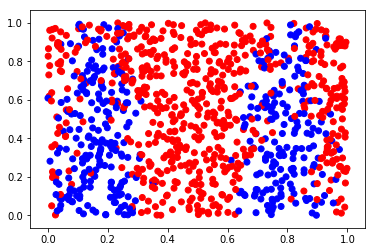

In [523]:
# Set the parameters
kernel='rbf'
params={'sigma':0.5}
lambs = [0.01, 0.1, 1]
folds=3

# Load the data
X_train, y_train, X_test, y_test = load_simulated_data(n=1000)

# Fit the model
acc_rbf_point5 = multiclass_svm(X_train, y_train, X_test, y_test, lambs=lambs, folds=3, kernel=kernel, params=params, 
                                 max_iter=1000, eps=1e-5, cross_validate=False, verbose=False)

# Print the accuracy
print('Accuracy of kernel {} with params {} : {}'.format(kernel, params, acc_rbf_point5))

X_train: (750, 2), y_train: (750,), X_test: (250, 2), y_test: (250,)
Accuracy of kernel poly with params {'order': 7} : 0.44


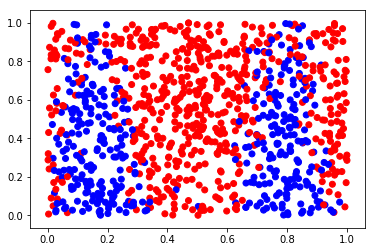

In [532]:
# Set the parameters
kernel='poly'
params={'order':7}
lambs = [1e-3]
folds=3

# Load the data
X_train, y_train, X_test, y_test = load_simulated_data(n=1000)

# Fit the model
acc_poly_7 = multiclass_svm(X_train, y_train, X_test, y_test, lambs=lambs, folds=3, kernel=kernel, params=params, 
                                 max_iter=1000, eps=1e-5, cross_validate=False, verbose=False)

# Print the accuracy
print('Accuracy of kernel {} with params {} : {}'.format(kernel, params, acc_poly_7))

In [529]:
from sklearn.svm import SVC

In [544]:
svm = SVC(kernel='poly', degree=7, C=1/(n*lambs[0])).fit(X_train, y_train)
print(svm.score(X_test, y_test))

0.6


In [536]:
sigma = 0.5
svm = SVC(kernel='rbf', gamma=1/(2*sigma**2)).fit(X_train, y_train)
print(svm.score(X_test, y_test))

0.816


### Compare performance to Sklearn

X_train: (750, 2), y_train: (750,), X_test: (250, 2), y_test: (250,)
Algorithm accuracy with kernel poly of degree7 and lambda 0.001 : 0.36
Skearn SVC accuracy of kernel poly of degree 7 and params 0.001 : 0.668


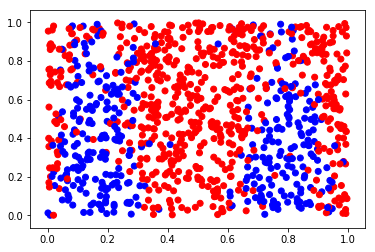

In [546]:
# Set the parameters
kernel='poly'
degree = 7
params={'order':degree}
lambs = [1e-3]
C = 1/(n*lambs[0])
folds=3

# Load the data
X_train, y_train, X_test, y_test = load_simulated_data(n=1000)

# Fit the model
acc_poly_7 = multiclass_svm(X_train, y_train, X_test, y_test, lambs=lambs, folds=3, kernel=kernel, params=params, 
                                 max_iter=1000, eps=1e-5, cross_validate=False, verbose=False)

# Print the accuracy
print('Algorithm accuracy with kernel {} of degree{} and lambda {} : {}'.format(kernel, degree, lambs[0], acc_poly_7))

svm = SVC(kernel=kernel, degree=degree, C=1/(n*lambs[0])).fit(X_train, y_train)
acc_sk = svm.score(X_test, y_test)
print('Skearn SVC accuracy of kernel {} of degree {} and params {} : {}'.format(kernel, degree, lambs[0], acc_sk))
